In [149]:
#@title Imports
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

In [151]:
#@title SpectralConv1d class

# Spectral / Fourier Layer class
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        """
        1D Fourier layer. FFT -> linear transform -> Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [152]:
#@title FNO1d class
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        Fourier Neural Operator class
        1 Linear Layer
        3 Fourier Layers
        1 Linear Layer
        Input: 2 input channels (u(x), x) at time a
        Output: 1 output channel u(x) time b
        """

        self.modes = modes
        self.width = width

        self.linear_p = nn.Linear(2, self.width)  
    
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):

        x = self.linear_p(x)
        x = x.permute(0, 2, 1)

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

In [153]:
#@title Seeding
torch.manual_seed(0)
np.random.seed(0)

In [154]:
#@title Loading data
n_train = 64 # number of training samples

# load the data
# only for t=0, t=1: train_sol.npy, test_sol.npy

train_val_data = torch.from_numpy(np.load("train_sol.npy")).type(torch.float32)
test_data      = torch.from_numpy(np.load("test_sol.npy")).type(torch.float32)

# creating grid of x values
x_values = np.linspace(0, 1, 64)
x_values = torch.tensor(x_values, dtype=torch.float32)

# training input, output
input_function_train = train_val_data[:n_train,0,:]
input_function_train = torch.stack([input_function_train, x_values.repeat(n_train, 1)], dim=-1)

output_function_train = train_val_data[:n_train,-1,:]
output_function_train = torch.stack([output_function_train, x_values.repeat(n_train, 1)], dim=-1)

# validation input, output
input_function_val = train_val_data[n_train:,0,:]
input_function_val = torch.stack([input_function_val, x_values.repeat(train_val_data.shape[0] - n_train, 1)], dim=-1)

output_function_val = train_val_data[n_train:,-1,:]
output_function_val = torch.stack([output_function_val, x_values.repeat(train_val_data.shape[0] - n_train, 1)], dim=-1)

# test input, output
input_function_test = test_data[:,0,:]
input_function_test = torch.stack([input_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

output_function_test = test_data[:,-1,:]
output_function_test = torch.stack([output_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

# batch size
batch_size = 10

training_set   = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
testing_set    = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)
validation_set = DataLoader(TensorDataset(input_function_val, output_function_val), batch_size=batch_size, shuffle=False)

In [155]:
#@title Hyperparameters and model
# training hyperparameters
learning_rate = 0.001
epochs = 250
step_size = 50
gamma = 0.5

# model parameters
modes = 16 
width = 64
fno = FNO1d(modes, width) 

In [156]:
#@title Training

# training with ADAM and scheduler
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# loss function
l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch)
        output_batch = output_batch[:, :, 0:1]
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    # validation
    with torch.no_grad():
        fno.eval()
        val_mse = 0.0
        for step, (input_batch, output_batch) in enumerate(validation_set):
            output_pred_batch = fno(input_batch)
            output_batch = output_batch[:, :, 0:1]
            loss_f = l(output_pred_batch, output_batch)
            val_mse += loss_f.item()
        val_mse /= len(validation_set)

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_batch = output_batch[:, :, 0:1]
            output_pred_batch = fno(input_batch)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("### Epoch:", epoch, " ### Train Loss:", train_mse, "### Validation Loss:", val_mse," ### Average relative L2 error:", test_relative_l2)
print("Training completed!")

### Epoch: 0  ### Train Loss: 0.028421025457126752 ### Validation Loss: 0.02104036057634013  ### Average relative L2 error: 80.63117218017578
### Epoch: 1  ### Train Loss: 0.01999834898327078 ### Validation Loss: 0.019203422857182368  ### Average relative L2 error: 78.15327453613281
### Epoch: 2  ### Train Loss: 0.019074193068913052 ### Validation Loss: 0.021012724111122743  ### Average relative L2 error: 81.07067636343149
### Epoch: 3  ### Train Loss: 0.018481102639010975 ### Validation Loss: 0.018836836463638713  ### Average relative L2 error: 77.53703132042519
### Epoch: 4  ### Train Loss: 0.017934763537985936 ### Validation Loss: 0.018786251278860227  ### Average relative L2 error: 78.59983825683594
### Epoch: 5  ### Train Loss: 0.01896148268133402 ### Validation Loss: 0.018458858531500612  ### Average relative L2 error: 76.55858435997597
### Epoch: 6  ### Train Loss: 0.018249434552022388 ### Validation Loss: 0.018394785401012217  ### Average relative L2 error: 74.96233162513145
##

In [157]:
# Compute relative L2 error on the test dataset
with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_set):
        output_batch = output_batch[:, :, 0:1]
        output_pred_batch = fno(input_batch)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(testing_set)

print(f"Average Relative L2 Error on Test Dataset: {test_relative_l2:.4f}%")

Average Relative L2 Error on Test Dataset: 12.2743%


In [158]:
#@title Testing on varying resolutions
resolutions = [32, 64, 96, 128]
relative_l2_errors = []

for res in resolutions:
    print(f"\nTesting FNO on resolution s = {res}")

    # Load data for the current resolution
    test_data = torch.from_numpy(np.load(f"test_sol_res_{res}.npy")).type(torch.float32)
    x_values = np.linspace(0, 1, res)
    x_values = torch.tensor(x_values, dtype=torch.float32)

    # Prepare input data
    input_function_test = test_data[:, 0, :]
    input_function_test = torch.stack([input_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

    # Prepare output data
    output_function_test = test_data[:, -1, :]
    output_function_test = torch.stack([output_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

    # Create DataLoader for the current resolution
    testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

    # Evaluate the model and compute relative L2 error
    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_batch = output_batch[:, :, 0:1]
            output_pred_batch = fno(input_batch)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    relative_l2_errors.append(test_relative_l2)
    print(f"Average Relative L2 Error: {test_relative_l2:.4f}%")

# Print summary of errors for all resolutions
print("\nSummary of Relative L2 Errors:")
for res, error in zip(resolutions, relative_l2_errors):
    print(f"Resolution {res}: {error:.4f}%")




Testing FNO on resolution s = 32
Average Relative L2 Error: 14.0526%

Testing FNO on resolution s = 64
Average Relative L2 Error: 12.3535%

Testing FNO on resolution s = 96
Average Relative L2 Error: 12.4397%

Testing FNO on resolution s = 128
Average Relative L2 Error: 13.1661%

Summary of Relative L2 Errors:
Resolution 32: 14.0526%
Resolution 64: 12.3535%
Resolution 96: 12.4397%
Resolution 128: 13.1661%


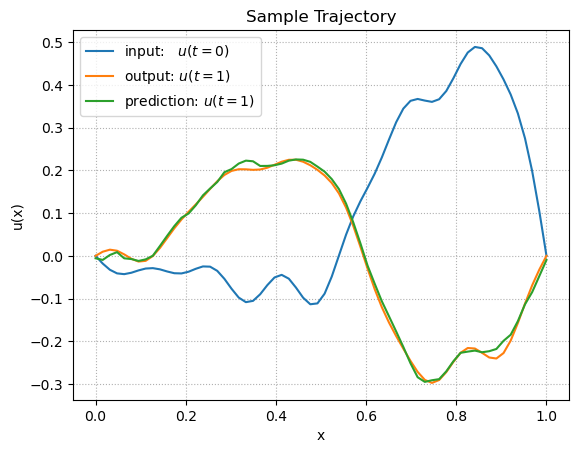

In [159]:
#@title Sample trajectory
id_sample = 33

prediction = fno(input_function_train[id_sample].unsqueeze(0))
prediction = prediction[0, :, 0].cpu().detach().numpy()

plt.plot(np.linspace(0,1,input_function_train.shape[1]),input_function_train[id_sample,:,0], label = "input:   $u(t = 0)$")
plt.plot(np.linspace(0,1,input_function_train.shape[1]),output_function_train[id_sample,:,0], label = "output: $u(t = 1)$")
plt.plot(np.linspace(0,1,input_function_train.shape[1]),prediction, label = "prediction: $u(t = 1)$")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Sample Trajectory")
plt.grid(True, which="both", ls=":")
plt.legend()

In [160]:
#@title Testing out of distribution
res = 64
# Load data for OOD testing
test_data = torch.from_numpy(np.load(f"test_sol_OOD.npy")).type(torch.float32)
x_values = np.linspace(0, 1, res)
x_values = torch.tensor(x_values, dtype=torch.float32)

# Prepare input data
input_function_test = test_data[:, 0, :]
input_function_test = torch.stack([input_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

# Prepare output data
output_function_test = test_data[:, -1, :]
output_function_test = torch.stack([output_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

# Create DataLoader for the OOD data
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

# Evaluate the model and compute relative L2 error
with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_set):
        output_batch = output_batch[:, :, 0:1]
        output_pred_batch = fno(input_batch)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(testing_set)

print(f"OOD Relative L2 Error: {test_relative_l2:.4f}%")

OOD Relative L2 Error: 16.0380%


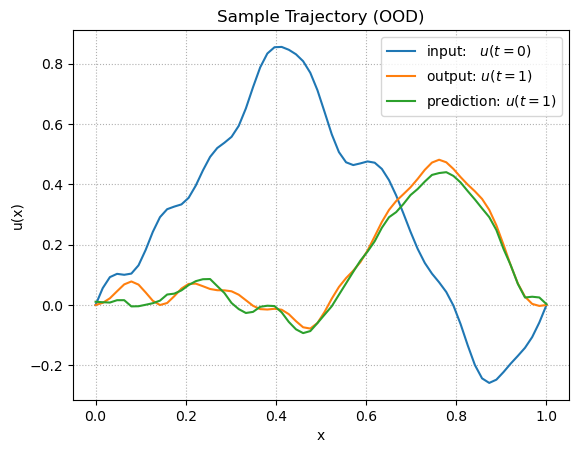

In [161]:
#@title Sample trajectory from OOD
id_sample = 24

prediction = fno(input_function_test[id_sample].unsqueeze(0))
prediction = prediction[0, :, 0].cpu().detach().numpy()

plt.plot(np.linspace(0,1,input_function_test.shape[1]),input_function_test[id_sample,:,0], label = "input:   $u(t = 0)$")
plt.plot(np.linspace(0,1,input_function_test.shape[1]),output_function_test[id_sample,:,0], label = "output: $u(t = 1)$")
plt.plot(np.linspace(0,1,input_function_test.shape[1]),prediction, label = "prediction: $u(t = 1)$")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Sample Trajectory (OOD)")
plt.grid(True, which="both", ls=":")
plt.legend()

In [162]:
#@title Time-conditional batch normalisation class
class FILM(torch.nn.Module):
    def __init__(self,
                channels,
                use_bn = True):
        super(FILM, self).__init__()
       
        self.channels  = channels
        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias  = nn.Linear(in_features=1, out_features=channels, bias=True)

        self.inp2scale.weight.data.fill_(0)
        self.inp2scale.bias.data.fill_(1)
        self.inp2bias.weight.data.fill_(0)
        self.inp2bias.bias.data.fill_(0)

        if use_bn:
          self.norm = nn.BatchNorm1d(channels)
        else:
          self.norm = nn.Identity()

    def forward(self, x, time):
        x     = self.norm(x)
        time  = time[:, 0, 0].reshape(-1, 1).type_as(x) # reshape [10, 1] -> [10, 64, 1]
        scale = self.inp2scale(time)
        bias  = self.inp2bias(time)
        # Expand scale and bias to match the dimensions of x
        scale = scale.unsqueeze(2).expand(-1, -1, x.shape[-1]) 
        bias  = bias.unsqueeze(2).expand(-1, -1, x.shape[-1])  

        return x * scale + bias


In [163]:
#@title Time-Dependent FNO class

# tFNO1d Class
class tFNO1d(nn.Module):
    def __init__(self, modes, width):
        super(tFNO1d, self).__init__()

        """
        Time-dependent Fourier Neural Operator, 1D
        Input:  (u(x),x) at time t_1, t_diff = t_2 - t_1
        Output: u(x) at time t_2
        """

        self.modes1 = modes
        self.width = width
        self.linear_p = nn.Linear(3, self.width)  # 3 input channels (u0(x), x, t)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0   = nn.Conv1d(self.width, self.width, 1)
        self.lin1   = nn.Conv1d(self.width, self.width, 1)
        self.lin2   = nn.Conv1d(self.width, self.width, 1)

        #batchnorms
        self.bn1    = FILM(channels=self.width)
        self.bn2    = FILM(channels=self.width)
        self.bn3    = FILM(channels=self.width)
        self.bn4    = FILM(channels=self.width)
        self.bn5    = FILM(channels=self.width)
        self.bn6    = FILM(channels=32)  # For linear_q output

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer, bn, time_diff):
        x = spectral_layer(x) + conv_layer(x)
        return self.activation(bn(x, time_diff)) 

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x, time_diff):
        x = torch.cat([x, time_diff], dim=-1)  # Concatenate time difference
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)

        x = self.fourier_layer(x, self.spect1, self.lin0, self.bn1, time_diff)
        x = self.fourier_layer(x, self.spect2, self.lin1, self.bn2, time_diff)
        x = self.fourier_layer(x, self.spect3, self.lin2, self.bn3, time_diff)

        x = self.linear_layer(x, self.linear_q)

        x = self.bn6(x.permute(0, 2, 1), time_diff).permute(0, 2, 1)  # Apply FILM and permute back
        x = self.output_layer(x)
        return x

In [164]:
#@title Data preparation
# Load the data
train_val_data = torch.from_numpy(np.load("train_sol.npy")).type(torch.float32)
n_train = 64
times = [0, 0.25, 0.5, 0.75, 1]

# Create training data pairs
input_data  = []
output_data = []
time_diff   = []
x_values    = np.linspace(0, 1, 64)
x_values    = torch.tensor(x_values, dtype=torch.float32)

for i in range(n_train):
  for j in range(len(times)):
    for k in range(j + 1, len(times)):
      # input: u(t=times[j]) and x coordinates
      input_func = train_val_data[i, j, :]
      input_func = torch.stack([input_func, x_values], dim=-1)

      # output: u(t=times[k]) and x coordinates
      output_func = train_val_data[i, k, :]
      output_func = torch.stack([output_func, x_values], dim=-1)

      # time difference
      time_difference = times[k] - times[j]

      input_data.append(input_func)
      output_data.append(output_func)
      time_diff.append(time_difference)

# convert to tensors
input_data  = torch.stack(input_data)
output_data = torch.stack(output_data)
time_diff   = torch.tensor(time_diff, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
time_diff   = time_diff.repeat(1,64,1)

print("\nInput data shape:      ",input_data.shape)
print("\nOutput data shape:     ",output_data.shape)
print("\nTime difference shape: ",time_diff.shape)



# Create training DataLoader
batch_size = 10
training_set = DataLoader(TensorDataset(input_data, time_diff, output_data), batch_size=batch_size, shuffle=True)


# Test data
test_data = torch.from_numpy(np.load("test_sol.npy")).type(torch.float32)

# test input, output
input_function_test = test_data[:,0,:]
input_function_test = torch.stack([input_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

output_function_test = test_data[:,-1,:]
output_function_test = torch.stack([output_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

test_time_diff = torch.ones(input_function_test.shape[0], 1, 1, dtype=torch.float32)
test_time_diff = test_time_diff.repeat(1, 64, 1)  # Repeat to match input dimensions

testing_set = DataLoader(TensorDataset(input_function_test, test_time_diff, output_function_test), batch_size)



Input data shape:       torch.Size([640, 64, 2])

Output data shape:      torch.Size([640, 64, 2])

Time difference shape:  torch.Size([640, 64, 1])


In [165]:
#@title tFNO training hyperparameters and model parameters
# hyperparameters
learning_rate = 0.001
epochs = 50
step_size = 50
gamma = 0.5

# model parameters
modes = 16 
width = 64
tfno = tFNO1d(modes, width)

In [166]:
#@title All2All Training

optimizer = Adam(tfno.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# loss function
l = torch.nn.MSELoss()
freq_print = 1

# training loop
for epoch in range(epochs):
    train_mse = 0.0
    train_relative_l2 = 0.0
    for step, (input_batch, time_diff_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = tfno(input_batch, time_diff_batch)
        output_batch = output_batch[:, :, 0:1]
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)
    scheduler.step()

    with torch.no_grad():
        tfno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, time_diff_batch, output_batch) in enumerate(testing_set):
            output_batch = output_batch[:, :, 0:1]
            output_pred_batch = tfno(input_batch, time_diff_batch)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)


    if epoch % freq_print == 0:
        if epoch % freq_print == 0: print("### Epoch:", epoch, " ### Train Loss:", train_mse," ### Relative L2 Test Norm:", test_relative_l2)

print("Training completed!")

### Epoch: 0  ### Train Loss: 0.04202281306788791  ### Relative L2 Test Norm: 69.44795579176683
### Epoch: 1  ### Train Loss: 0.016905257507460192  ### Relative L2 Test Norm: 58.78037936870869
### Epoch: 2  ### Train Loss: 0.014609389923862182  ### Relative L2 Test Norm: 50.970243600698616
### Epoch: 3  ### Train Loss: 0.012494804665038828  ### Relative L2 Test Norm: 44.41637948843149
### Epoch: 4  ### Train Loss: 0.011637854142463766  ### Relative L2 Test Norm: 42.971797943115234
### Epoch: 5  ### Train Loss: 0.010358767867728602  ### Relative L2 Test Norm: 45.36640431330754
### Epoch: 6  ### Train Loss: 0.01038376417272957  ### Relative L2 Test Norm: 43.7776973430927
### Epoch: 7  ### Train Loss: 0.009630369240767322  ### Relative L2 Test Norm: 41.22317974384014
### Epoch: 8  ### Train Loss: 0.008667002875881735  ### Relative L2 Test Norm: 41.04058251014123
### Epoch: 9  ### Train Loss: 0.0082419794271118  ### Relative L2 Test Norm: 39.909033848689155
### Epoch: 10  ### Train Loss: 0

In [167]:
# Evaluate the model on the test set and compute the average relative L2 error
with torch.no_grad():
    tfno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, time_diff_batch, output_batch) in enumerate(testing_set):
        output_batch = output_batch[:, :, 0:1]
        output_pred_batch = tfno(input_batch, time_diff_batch)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(testing_set)

print(f"Average Relative L2 Error on Test Dataset: {test_relative_l2:.4f}%")

Average Relative L2 Error on Test Dataset: 40.3357%


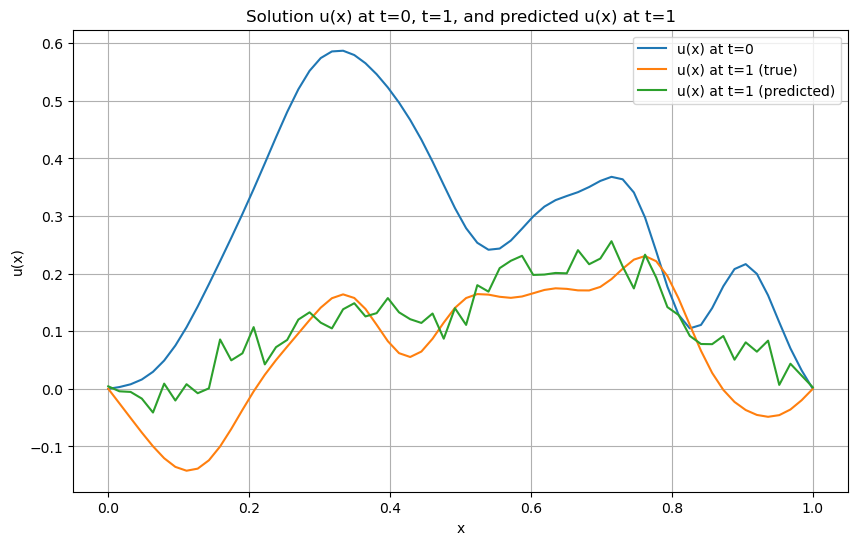

In [168]:
#@title Sample prediction
# take one sample from the testing set
sample_index = 5  # change this to visualize a different sample
for step, (input_batch, time_diff_batch, output_batch) in enumerate(testing_set):
  if step == sample_index:
    input_sample = input_batch[0]
    time_diff_sample = time_diff_batch[0]
    output_sample = output_batch[0]
    break

# get the model's prediction for the sample
with torch.no_grad():
    tfno.eval()
    output_pred_sample = tfno(input_sample.unsqueeze(0), time_diff_sample.unsqueeze(0))

# extract u(x) values
u_x_t0 = input_sample[:, 0].cpu().numpy()
u_x_t1 = output_sample[:, 0].cpu().numpy()
u_x_t1_pred = output_pred_sample[0, :, 0].cpu().numpy()

# Plot the results
x_values = np.linspace(0, 1, 64) # Assuming 64 points
plt.figure(figsize=(10, 6))
plt.plot(x_values, u_x_t0, label="u(x) at t=0")
plt.plot(x_values, u_x_t1, label="u(x) at t=1 (true)")
plt.plot(x_values, u_x_t1_pred, label="u(x) at t=1 (predicted)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Solution u(x) at t=0, t=1, and predicted u(x) at t=1")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/kg/v_23pd4d08z7wvxt6x57g5zr0000gn/T/ipykernel_14209/3153414703.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t0 = torch.stack([torch.tensor(input_t0), torch.tensor(x_values, dtype=torch.float32)], dim=-1).unsqueeze(0)


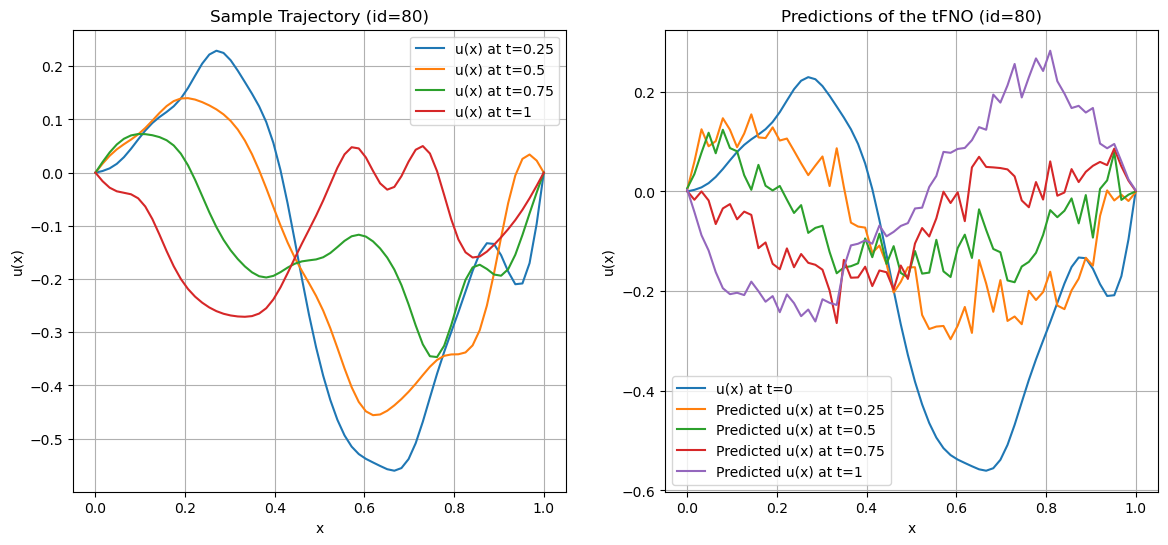

<Figure size 1000x600 with 0 Axes>

In [169]:
#@title Sample prediction (multiple)

# take one sample from the testing set, visualize all five time snapshots
id_sample = 80
train_val_data = torch.from_numpy(np.load("train_sol.npy")).type(torch.float32)

# time_diffs = [0, 0.25, 0.5, 0.75, 1] 
time_diffs = [0.25, 0.5, 0.75, 1] 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  

for i, t in enumerate(time_diffs):
    u_x_t = train_val_data[id_sample, i, :]
    ax1.plot(x_values, u_x_t, label=f"u(x) at t={t}")

ax1.set_xlabel("x")
ax1.set_ylabel("u(x)")
ax1.set_title(f"Sample Trajectory (id={id_sample})")
ax1.legend()
ax1.grid(True)

# predictions of the tFNO
plt.figure(figsize=(10, 6))
input_t0 = train_val_data[id_sample, 0, :]
u_x_t = train_val_data[id_sample, 0, :]
ax2.plot(x_values, u_x_t, label=f"u(x) at t=0")

input_t0 = torch.stack([torch.tensor(input_t0), torch.tensor(x_values, dtype=torch.float32)], dim=-1).unsqueeze(0)
for t_diff in time_diffs:
  time_diff_tensor = torch.tensor([t_diff]).unsqueeze(-1).unsqueeze(-1).repeat(1, 64, 1)
  with torch.no_grad():
      tfno.eval()
      output_pred = tfno(input_t0, time_diff_tensor)
  u_x_pred = output_pred[0, :, 0].cpu().numpy()
  ax2.plot(x_values, u_x_pred, label=f"Predicted u(x) at t={t_diff}")

ax2.set_xlabel("x")
ax2.set_ylabel("u(x)")
ax2.set_title(f"Predictions of the tFNO (id={id_sample})")
ax2.legend()
ax2.grid(True)
plt.show()

In [170]:
#@title Preparing multiple time-diff datasets

test_data = torch.from_numpy(np.load("test_sol.npy")).type(torch.float32)
x_values  = np.linspace(0, 1, 64) 
x_values  = torch.tensor(x_values, dtype=torch.float32)
times     = [0, 0.25, 0.5, 0.75, 1] 

# dictionary to store the testing sets for different time differences
testing_sets = {}

for target_time in times: 
    input_function_test_list = []
    output_function_test_list = []
    time_diff_list = []
    for i in range(test_data.shape[0]):  
      for time_idx, current_time in enumerate(times):
          if current_time == target_time:
            # input data
            input_function_test  = test_data[i, 0, :]
            input_function_test  = torch.stack([input_function_test, x_values], dim=-1)

            # output data for the target time
            output_function_test = test_data[i, time_idx, :]
            output_function_test = torch.stack([output_function_test, x_values], dim=-1)

            # time difference
            time_difference      = target_time
            time_diff_list.append(time_difference)
            input_function_test_list.append(input_function_test)
            output_function_test_list.append(output_function_test)

    # convert list to tensor
    input_function_test_tensor  = torch.stack(input_function_test_list)
    output_function_test_tensor = torch.stack(output_function_test_list)
    time_diff_tensor            = torch.tensor(time_diff_list, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1).repeat(1,64,1)

    # DataLoader
    testing_set = DataLoader(TensorDataset(input_function_test_tensor, time_diff_tensor, output_function_test_tensor), batch_size=10, shuffle=False)
    testing_sets[target_time] = testing_set

In [171]:
#@title Testing on various time-differences
times = [0.25, 0.5, 0.75, 1]
relative_l2_errors_by_time = {}

with torch.no_grad():
    tfno.eval()
    for t in times:
        test_relative_l2 = 0.0
        testing_set = testing_sets[t]
        for step, (input_batch, time_diff_batch, output_batch) in enumerate(testing_set):
            output_batch = output_batch[:, :, 0:1]
            
            current_time_diff = torch.full_like(time_diff_batch, t)
            output_pred_batch = tfno(input_batch, current_time_diff)
            
            loss_f = (torch.mean((output_pred_batch - output_batch)**2) / torch.mean(output_batch**2))**0.5 * 100
            test_relative_l2 += loss_f.item()

        test_relative_l2 /= len(testing_set)
        relative_l2_errors_by_time[t] = test_relative_l2
        print(f"Average Relative L2 Error for t={t}: {test_relative_l2:.4f}%")

print("\nSummary of Relative L2 Errors by Time:")
for t, error in relative_l2_errors_by_time.items():
    print(f"Time {t}: {error:.4f}%")

Average Relative L2 Error for t=0.25: 36.1319%
Average Relative L2 Error for t=0.5: 47.4240%
Average Relative L2 Error for t=0.75: 49.4461%
Average Relative L2 Error for t=1: 40.3357%

Summary of Relative L2 Errors by Time:
Time 0.25: 36.1319%
Time 0.5: 47.4240%
Time 0.75: 49.4461%
Time 1: 40.3357%


In [172]:
#@title OOD Testing for time-dependent FNO

res = 64
# load data for OOD testing
test_data = torch.from_numpy(np.load(f"test_sol_OOD.npy")).type(torch.float32)
x_values  = np.linspace(0, 1, res)
x_values  = torch.tensor(x_values, dtype=torch.float32)

# input data
input_function_test  = test_data[:, 0, :]
input_function_test  = torch.stack([input_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

# output data
output_function_test = test_data[:, -1, :]
output_function_test = torch.stack([output_function_test, x_values.repeat(test_data.shape[0], 1)], dim=-1)

# time difference
time_diff = torch.ones(input_function_test.shape[0], 1, 1, dtype=torch.float32)
time_diff = time_diff.repeat(1, 64, 1)

# DataLoader
testing_set = DataLoader(TensorDataset(input_function_test, time_diff, output_function_test), batch_size=batch_size, shuffle=False)

# compute relative L2 error
with torch.no_grad():
    tfno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, time_diff_batch, output_batch) in enumerate(testing_set):
        output_batch = output_batch[:, :, 0:1]
        output_pred_batch = tfno(input_batch,time_diff_batch)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(testing_set)

print(f"OOD Relative L2 Error: {test_relative_l2:.4f}%")

OOD Relative L2 Error: 48.7454%
